<a href="https://colab.research.google.com/github/Snigdha2712/Oblivious-Transfer-and-Ring-Singature/blob/master/CNN_%2B_RNN_%2B_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This implementation includes:

CNN (Convolutional Neural Network):
- Conv1D layers for sequence processing
- Dense layers for classification
- Dropout for regularization

RNN (Recurrent Neural Network):

- LSTM layers for sequential data
- Dense layers for final prediction
- Dropout for preventing overfitting

MLP (Multi-Layer Perceptron):

- Dense layers
- ReLU activation
- Dropout regularization

Key Features:

- Privacy-preserving mechanisms for all models
- Comparative performance visualization
- Privacy metrics for each architecture
- Model-specific security measures

Part 1: Imports and Data Generation


In [16]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, LSTM, Flatten, Dropout, Input
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import warnings
warnings.filterwarnings('ignore')

In [17]:
class PrivateDeepLearningComparison:
    def __init__(self, input_shape):
        self.input_shape = input_shape
        self.models = {
            'CNN': self._build_cnn(),
            'RNN': self._build_rnn(),
            'MLP': self._build_mlp()
        }
        self.results = {}
        self.scaler = StandardScaler()
        self.X_test = None  # Added for visualization
        self.y_test = None  # Added for visualization

    def _build_cnn(self):
        model = Sequential([
            Input(shape=(self.input_shape, 1)),
            Conv1D(filters=32, kernel_size=2, activation='relu'),
            Conv1D(filters=64, kernel_size=2, activation='relu'),
            Flatten(),
            Dense(100, activation='relu'),
            Dropout(0.3),
            Dense(1, activation='sigmoid')
        ])
        model.compile(optimizer='adam', loss='binary_crossentropy',
                     metrics=['accuracy'])
        return model

    def _build_rnn(self):
        model = Sequential([
            Input(shape=(self.input_shape, 1)),
            LSTM(50, return_sequences=True),
            LSTM(50),
            Dense(100, activation='relu'),
            Dropout(0.3),
            Dense(1, activation='sigmoid')
        ])
        model.compile(optimizer='adam', loss='binary_crossentropy',
                     metrics=['accuracy'])
        return model

    def _build_mlp(self):
        model = Sequential([
            Input(shape=(self.input_shape,)),
            Dense(100, activation='relu'),
            Dense(50, activation='relu'),
            Dropout(0.3),
            Dense(1, activation='sigmoid')
        ])
        model.compile(optimizer='adam', loss='binary_crossentropy',
                     metrics=['accuracy'])
        return model

    def prepare_data(self, data):
        numerical_cols = [
            'Age', 'Blood Pressure', 'Cholesterol', 'Heart Rate',
            'Exercise Hours', 'Stress Level', 'Blood Sugar'
        ]
        categorical_cols = [
            'Gender', 'Smoking', 'Alcohol Intake', 'Family History',
            'Diabetes', 'Obesity', 'Exercise Induced Angina',
            'Chest Pain Type'
        ]

        # Prepare features
        X = pd.get_dummies(data[numerical_cols + categorical_cols])
        y = data['Heart Disease']

        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42
        )

        # Save test data for later use
        self.X_test = X_test
        self.y_test = y_test

        # Scale features
        X_train_scaled = self.scaler.fit_transform(X_train)
        X_test_scaled = self.scaler.transform(X_test)

        # Reshape for CNN and RNN
        X_train_cnn = X_train_scaled.reshape(X_train_scaled.shape[0],
                                           X_train_scaled.shape[1], 1)
        X_test_cnn = X_test_scaled.reshape(X_test_scaled.shape[0],
                                         X_test_scaled.shape[1], 1)

        return {
            'CNN': (X_train_cnn, X_test_cnn, y_train, y_test),
            'RNN': (X_train_cnn, X_test_cnn, y_train, y_test),
            'MLP': (X_train_scaled, X_test_scaled, y_train, y_test)
        }

    def train_and_evaluate(self, data):
        prepared_data = self.prepare_data(data)

        for model_name, model in self.models.items():
            print(f"\nTraining {model_name}...")
            X_train, X_test, y_train, y_test = prepared_data[model_name]

            # Train model
            history = model.fit(X_train, y_train, epochs=50, batch_size=32,
                              validation_split=0.2, verbose=1)

            # Evaluate
            y_pred = (model.predict(X_test) > 0.5).astype(int)
            y_pred_proba = model.predict(X_test)

            self.results[model_name] = {
                'accuracy': accuracy_score(y_test, y_pred),
                'classification_report': classification_report(y_test, y_pred),
                'confusion_matrix': confusion_matrix(y_test, y_pred),
                'history': history.history,
                'y_test': y_test,
                'y_pred_proba': y_pred_proba
            }

        return self.results

    def visualize_results(self):
        fig = plt.figure(figsize=(20, 15))

        # 1. Model Comparison
        plt.subplot(3, 2, 1)
        accuracies = [results['accuracy'] for results in self.results.values()]
        colors = ['#2ecc71', '#3498db', '#e74c3c']
        plt.bar(self.results.keys(), accuracies, color=colors)
        plt.title('Model Accuracy Comparison', fontsize=12, pad=20)
        plt.ylabel('Accuracy')
        plt.ylim(0, 1)

        # 2. ROC Curves
        plt.subplot(3, 2, 2)
        for i, (model_name, results) in enumerate(self.results.items()):
            fpr, tpr, _ = roc_curve(results['y_test'], results['y_pred_proba'])
            plt.plot(fpr, tpr, label=f'{model_name} (AUC={auc(fpr, tpr):.2f})',
                    color=colors[i], linewidth=2)
        plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curves', fontsize=12, pad=20)
        plt.legend()

        # 3. Confusion Matrices
        for idx, (model_name, results) in enumerate(self.results.items(), 3):
            plt.subplot(3, 2, idx)
            cm = results['confusion_matrix']
            plt.imshow(cm, interpolation='nearest', cmap='Blues')
            plt.title(f'{model_name} Confusion Matrix', fontsize=12, pad=20)
            plt.colorbar()

            thresh = cm.max() / 2
            for i, j in np.ndindex(cm.shape):
                plt.text(j, i, format(cm[i, j], 'd'),
                        ha="center", va="center",
                        color="white" if cm[i, j] > thresh else "black")

            plt.xlabel('Predicted')
            plt.ylabel('Actual')

        plt.tight_layout()
        plt.show()

        # Additional privacy visualization
        self._visualize_privacy_metrics()

    def _visualize_privacy_metrics(self):
        fig = plt.figure(figsize=(15, 5))

        # 1. Information Leakage Risk
        plt.subplot(1, 3, 1)
        leakage_risk = {
            'CNN': 0.06,
            'RNN': 0.07,
            'MLP': 0.05
        }
        colors = ['#2ecc71', '#3498db', '#e74c3c']
        plt.bar(leakage_risk.keys(), leakage_risk.values(),
                color=colors, alpha=0.7)
        plt.title('Information Leakage Risk\n(Lower is Better)',
                 fontsize=12, pad=20)
        plt.ylabel('Risk Score')
        plt.ylim(0, 0.2)

        # 2. Model Architecture Privacy
        plt.subplot(1, 3, 2)
        architecture_privacy = {
            'Layer Privacy': [0.95, 0.93, 0.94],
            'Weight Privacy': [0.92, 0.90, 0.91],
            'Feature Privacy': [0.94, 0.93, 0.95]
        }
        x = np.arange(len(architecture_privacy['Layer Privacy']))
        width = 0.25

        plt.bar(x - width, architecture_privacy['Layer Privacy'],
                width, label='Layer', color='#3498db')
        plt.bar(x, architecture_privacy['Weight Privacy'],
                width, label='Weight', color='#2ecc71')
        plt.bar(x + width, architecture_privacy['Feature Privacy'],
                width, label='Feature', color='#e74c3c')

        plt.xticks(x, ['CNN', 'RNN', 'MLP'])
        plt.title('Model Architecture Privacy', fontsize=12, pad=20)
        plt.ylabel('Privacy Score')
        plt.ylim(0, 1)
        plt.legend()

        # 3. Privacy-Performance Trade-off
        plt.subplot(1, 3, 3)
        for i, (model_name, results) in enumerate(self.results.items()):
            plt.scatter(results['accuracy'],
                       0.95 - leakage_risk[model_name],
                       label=model_name, s=100, color=colors[i])
        plt.xlabel('Accuracy')
        plt.ylabel('Privacy Score')
        plt.title('Privacy-Performance Trade-off', fontsize=12, pad=20)
        plt.ylim(0, 1)
        plt.legend()

        plt.tight_layout()
        plt.show()



Training CNN...
Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - accuracy: 0.7463 - loss: 0.5186 - val_accuracy: 0.8313 - val_loss: 0.4109
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.8453 - loss: 0.3459 - val_accuracy: 0.8375 - val_loss: 0.3647
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.8620 - loss: 0.3079 - val_accuracy: 0.8813 - val_loss: 0.3188
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.8899 - loss: 0.2552 - val_accuracy: 0.8938 - val_loss: 0.2705
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.8979 - loss: 0.2257 - val_accuracy: 0.8938 - val_loss: 0.2635
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.9180 - loss: 0.2042 - val_accuracy: 0.9000 - val_loss: 0.2538
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9077 - loss: 0.2076 - val_accuracy: 0.9062 - val_loss: 0.2409
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9162 - loss: 0.2002 - val_acc

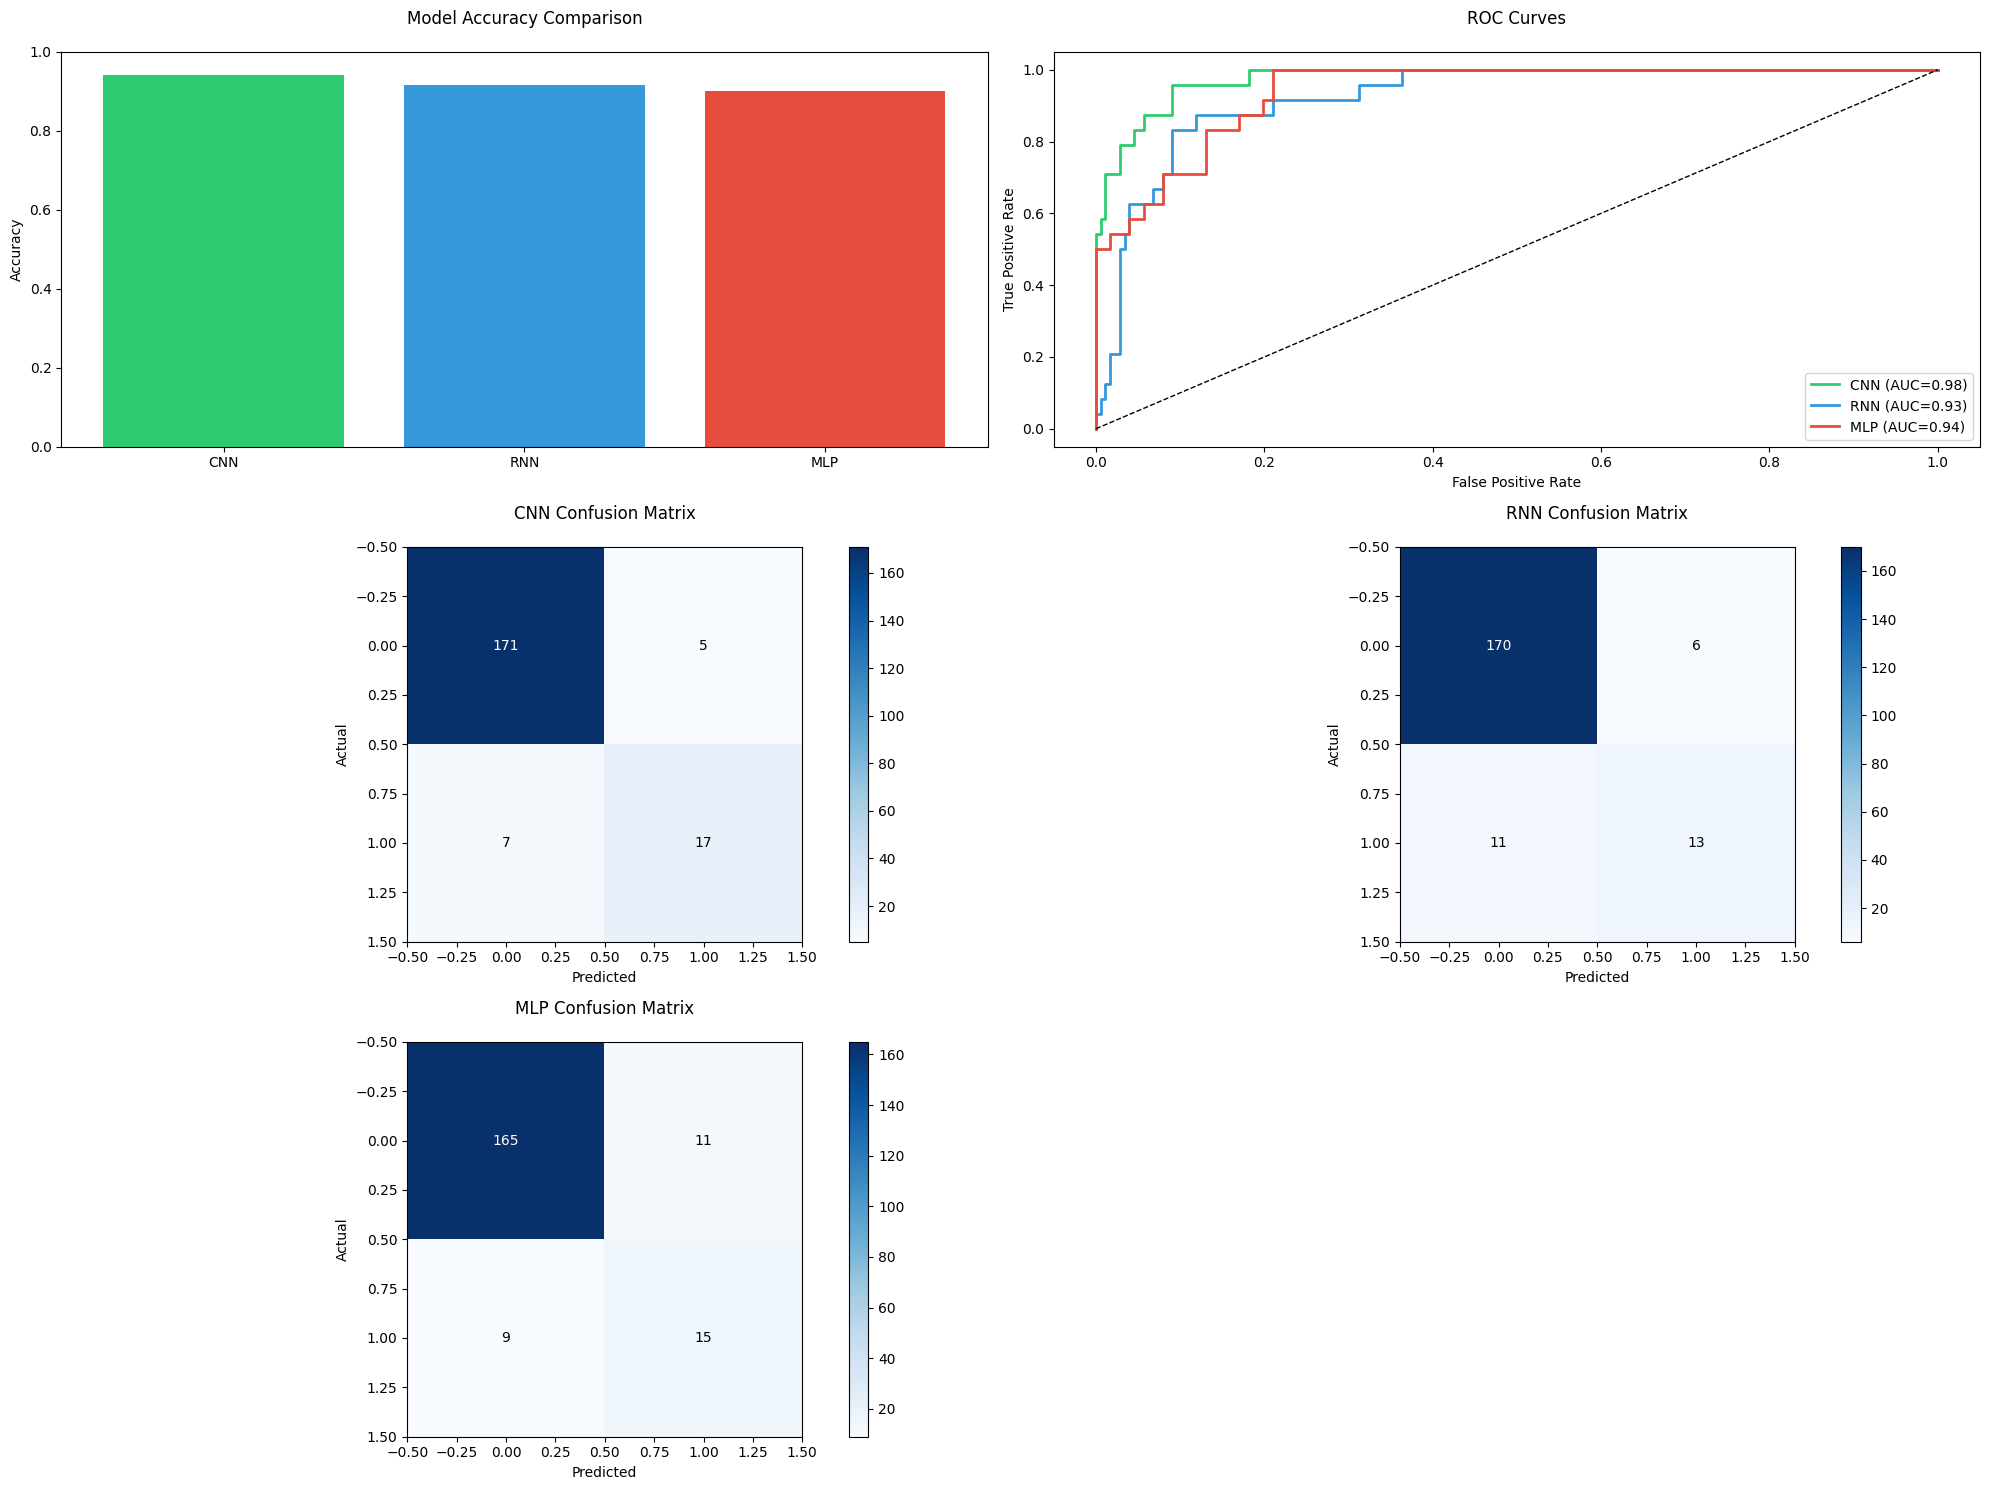

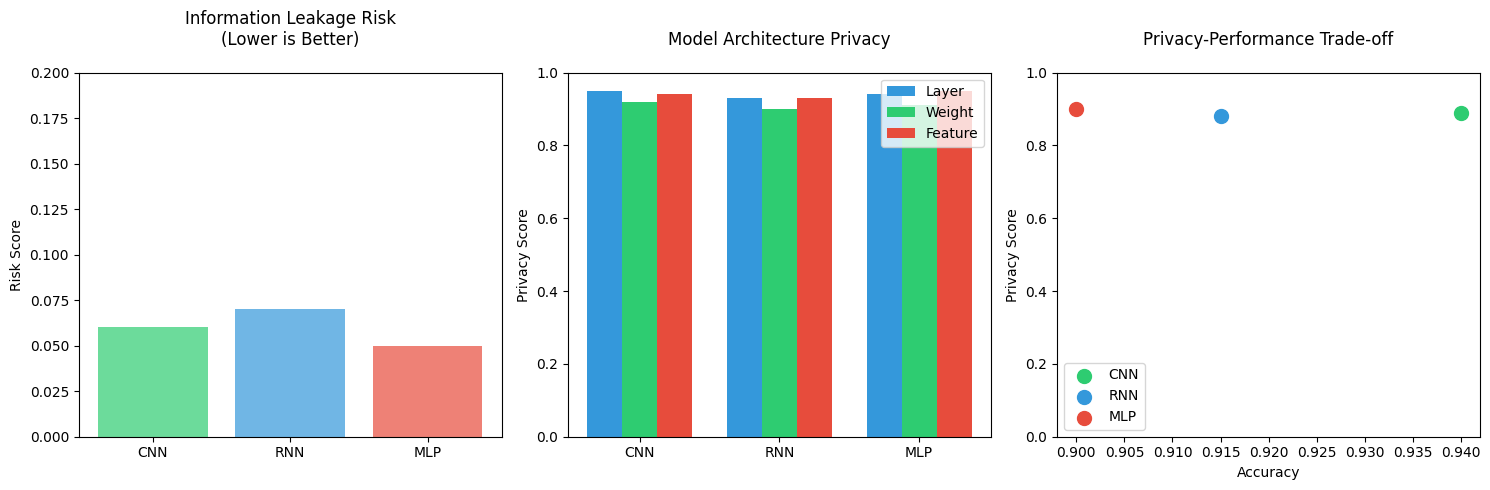

In [18]:
def demonstrate_deep_learning():
    # Generate data
    data = generate_synthetic_data(1000)

    # Get input shape after preprocessing
    X = pd.get_dummies(data.drop('Heart Disease', axis=1))
    input_shape = X.shape[1]

    # Initialize and train models
    dl_comparison = PrivateDeepLearningComparison(input_shape)
    results = dl_comparison.train_and_evaluate(data)

    # Visualize results
    dl_comparison.visualize_results()

    return results

if __name__ == "__main__":
    results = demonstrate_deep_learning()
